In [352]:
import cv2
import imutils
from PIL import Image
from matplotlib import pyplot as plt
import glob

In [351]:
NUM_TEAMS = 4
class_indices_list =['01_purple', '02_green', '03_white', '04_colored']
videos_folder = r'd:\ML\data\f\video\\20200212'
images_folder  = r'd:\ML\data\f\images\\'

In [4]:


video_files = [f for f in glob.glob(videos_folder + "**/*.mp4", recursive=True)]
video_files

['d:\\ML\\data\\f\\video\\20200212\\CAM00003.mp4']

In [7]:
import cv2
import uuid
def getFramesFromVideo(video_filename):
    vidcap = cv2.VideoCapture(video_filename)
    def getFrame(sec):
        vidcap.set(cv2.CAP_PROP_POS_MSEC,sec*1000)
        hasFrames,image = vidcap.read()
        if hasFrames:
            image = imutils.rotate(image, 180)
            cv2.imwrite(images_folder+ date_str+"_"+str(count)+uuid.uuid4().hex+".jpg", image)     # save frame as JPG file
        return hasFrames
    sec = 0
    frameCaptureRate = 60*3.4 #//it will capture image in each frameCaptureRate seconds
    count=0
    success = True
    while success:        
        sec = sec + frameCaptureRate
        sec = round(sec, 2)
        success = getFrame(sec)
        if success:
            count += 1
    vidcap.release()
    print(count,' images extracted from ', video_filename)

In [191]:
class Settings:
    def __init__(self, model_path, threshold, videos, out_images_folder, frameCaptureRateSec):
        self.model_path = model_path
        self.threshold = threshold
        self.videos = videos
        self.out_images_folder = out_images_folder
        self.frameCaptureRateSec = frameCaptureRateSec
settings = Settings(model_path=r'D:\ML\models\faster_rcnn_inception_v2_coco_2018_01_28/frozen_inference_graph.pb',
                   threshold=0.6,
                   videos=video_files,
                    out_images_folder=images_folder+r'\\0212\\',
                    frameCaptureRateSec=5
                   )

### settings = dict(model_path=r'D:\ML\models\faster_rcnn_inception_v2_coco_2018_01_28/frozen_inference_graph.pb',
                    threshold=0.6,
                    videos=video_files,
                    out_images_folder=images_folder+r'\\0212\\',
                    frameCaptureRateSec=60
                   )
settings

In [9]:
import os
import numpy as np
import time
from DetectorAPI import DetectorAPI

In [192]:
import uuid
import time
import cv2
import os
from DetectorAPI import DetectorAPI
for video_filename in settings.videos:
    start=time.time()
    cap = cv2.VideoCapture(video_filename)
    framecount = cap.get(cv2.CAP_PROP_FRAME_COUNT ) 
    frames_per_sec = cap.get(cv2.CAP_PROP_FPS)
    durationSec = framecount / frames_per_sec
    sec=0

    odapi = DetectorAPI(path_to_ckpt=settings.model_path)
    #durationSec = 1880
    n=int((durationSec-sec) / settings.frameCaptureRateSec + 1)
    all_counts=np.zeros(shape=(n, NUM_TEAMS), dtype=np.int)
    k=0
    while sec < durationSec:
        cap.set(cv2.CAP_PROP_POS_MSEC,sec*1000)   
        success, img = cap.read()
        if success:
            print('*', end='')
            crop_images = []
            boxes, scores, classes, num = odapi.processFrame(img)
            for box, score, class_ in zip(boxes, scores, classes):
                # Class 1 represents human
                if class_ == 1 and score >= settings.threshold:
                    (xA, yA, xB, yB) = box
                    crop_image = img[xA:xB,yA:yB,:]
                    crop_images.append((crop_image, box))
                   
            #TODO: think about using callback 
            save_cropped_images = False
            if save_cropped_images:
                i=0
                for crop_image, box in crop_images:
                    filepath = os.path.join(settings.out_images_folder, str(sec) +'_'+str(i)+'_'+ os.path.splitext(os.path.basename(video_filename))[0] + '_'+uuid.uuid4().hex[:6]+".jpg")
                    cv2.imwrite( filepath, crop_image)
                    i+=1
            if any(crop_images):
                team_ids = teamRecognizer.predict(crop_images)
                
                b = Counter(team_ids)
                counts = b.most_common()
                print(sec//60, ':', sec%60, '  -  ', [class_indices_list[x[0]] for x in counts[:2]], [_[1] for _ in counts[:2]])
                
                counts = np.bincount(team_ids)
                all_counts[k][0:len(counts)] = counts
                #print(sec, team_ids)
                    
        key = cv2.waitKey(1)
        if key & 0xFF == ord('q'):
            break
        sec += settings.frameCaptureRateSec
        k+=1
    cap.release()  
    finish=time.time()
    print('\n', video_filename ,'was processed for' , str((finish-start)/60.) , 'minutes')

*0 : 0   -   ['04_colored', '02_green'] [1, 1]
*0 : 5   -   ['03_white'] [1]
*0 : 10   -   ['03_white', '02_green'] [1, 1]
*0 : 15   -   ['01_purple', '02_green'] [1, 1]
*0 : 20   -   ['01_purple'] [2]
**0 : 30   -   ['02_green'] [1]
*0 : 35   -   ['01_purple', '02_green'] [1, 1]
*0 : 40   -   ['02_green'] [1]
*0 : 45   -   ['02_green', '03_white'] [2, 1]
*0 : 50   -   ['02_green'] [1]
*0 : 55   -   ['03_white', '02_green'] [2, 1]
*1 : 0   -   ['02_green', '03_white'] [1, 1]
***1 : 15   -   ['02_green'] [1]
*1 : 20   -   ['03_white'] [1]
*1 : 25   -   ['02_green'] [1]
*1 : 30   -   ['03_white'] [1]
**1 : 40   -   ['04_colored'] [1]
*1 : 45   -   ['03_white'] [1]
*1 : 50   -   ['01_purple'] [1]
****2 : 10   -   ['02_green'] [1]
**2 : 20   -   ['02_green'] [2]
*2 : 25   -   ['02_green', '01_purple'] [5, 1]
*2 : 30   -   ['02_green', '01_purple'] [5, 2]
*2 : 35   -   ['03_white', '02_green'] [4, 3]
*2 : 40   -   ['02_green', '04_colored'] [3, 1]
*2 : 45   -   ['03_white', '02_green'] [3, 

In [237]:
all_counts.shape

(630, 4)

In [203]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(81, 6), dpi=80, facecolor='w', edgecolor='k')

<Figure size 6480x480 with 0 Axes>

<Figure size 6480x480 with 0 Axes>

In [263]:
def movingaverage (values, window=6):
    weights = np.repeat(1.0, window)/window
    sma = np.convolve(values, weights, 'valid')
    return sma

In [250]:
ma0 = movingaverage(all_counts[:,0])
ma1 = movingaverage(all_counts[:,1])
ma2 = movingaverage(all_counts[:,2])
ma3 = movingaverage(all_counts[:,3])
ma0.shape

(619,)

In [271]:
all_counts.shape

(630, 4)

In [268]:

np.repeat(1.0, window)/window

array([0.16666667, 0.16666667, 0.16666667, 0.16666667, 0.16666667,
       0.16666667])

In [341]:
window=24
ma = np.full(shape=(630+window-1, NUM_TEAMS), fill_value=np.nan)
for i in range(NUM_TEAMS):
    ma[:,i] =  smooth(all_counts[:,i], window)

In [314]:
smooth(all_counts[:,i], window).shape

(641,)

In [244]:
plt.rcParams["figure.figsize"] = (25,3)

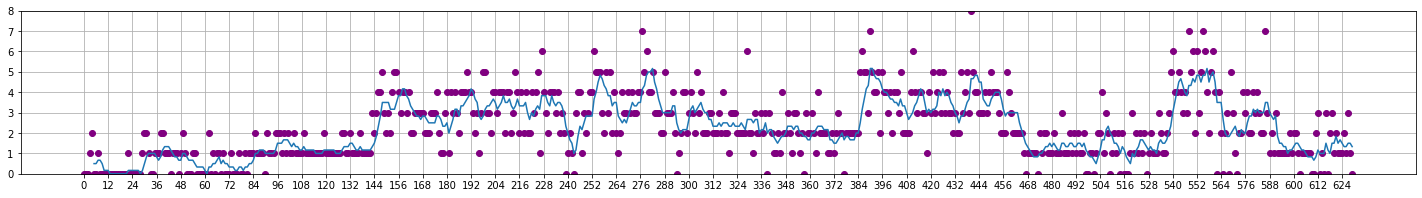

In [274]:
plt.grid(True)
plt.ylim((0,8))
plt.xticks(np.arange(0, 630, 12))
plt.plot(all_counts[:,0],'o', color='purple')
plt.plot(ma[:,0],'-')


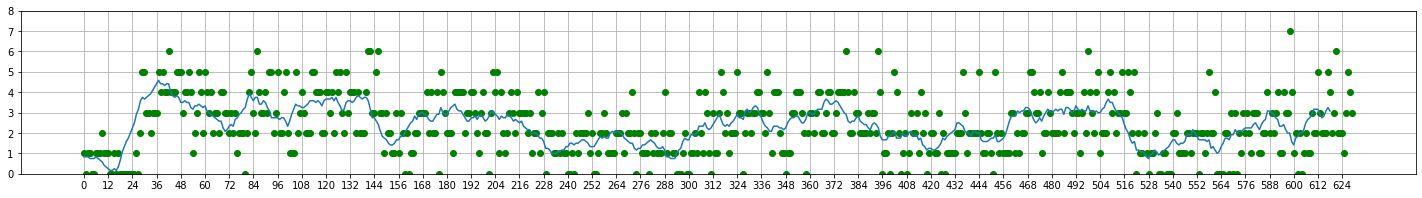

In [252]:
plt.grid(True)
plt.ylim((0,8))
plt.xticks(np.arange(0, 630, 12))
plt.plot(all_counts[:,1],'o', color='green')
plt.plot(ma[:,1],'-')

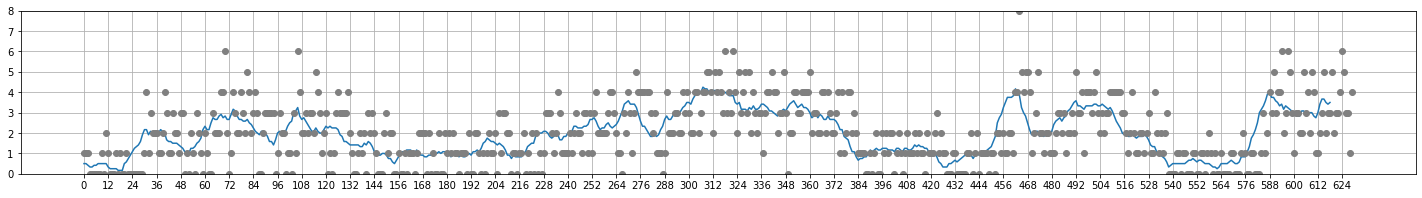

In [253]:
plt.grid(True)
plt.ylim((0,8))
plt.xticks(np.arange(0, 630, 12))
plt.plot(ma[:,2],'-')
plt.plot(all_counts[:,2],'o', color='gray')

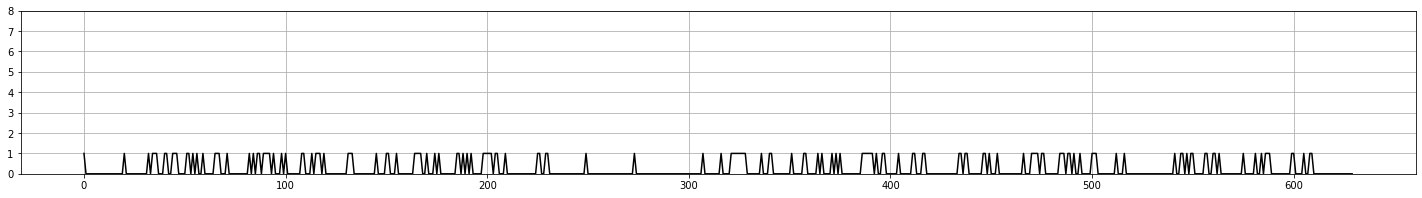

In [227]:
plt.grid(True)
plt.ylim((0,8))
plt.plot(all_counts[:,3], color='black')

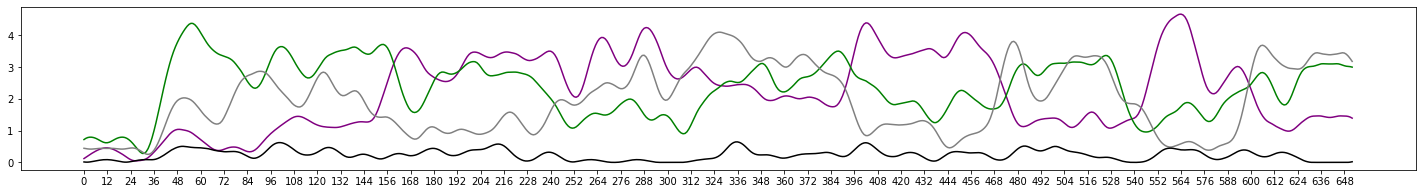

In [344]:
x = np.arange(ma.shape[0])

plt.gca().set_prop_cycle(color=['purple', 'green', 'gray', 'black'])

plt.plot(x, ma[:,0])
plt.plot(x, ma[:,1])
plt.plot(x, ma[:,2])
plt.plot(x, ma[:,3])

#plt.legend(['y = x', 'y = 2x', 'y = 3x', 'y = 4x'], loc='upper left')
plt.xticks(np.arange(0, ma.shape[0], 12))
plt.show()


In [342]:
teams = np.sort(np.argsort(ma, axis=-1)[:,-2:], axis=-1)
teams

array([[1, 2],
       [1, 2],
       [1, 2],
       ...,
       [1, 2],
       [1, 2],
       [1, 2]], dtype=int64)

In [350]:
current =np.array([])
k=0
for i in range(630):
    if not np.array_equal(current, teams[i,:]):
        
        if True:#i-k > 12: #one minute
            print((i*5 -24 *5)//60,':', (i*5 -24 *5)%60, (i-k) / 12,  current)
        current = teams[i,:]
        k=i
    

-2 : 0 0.0 []
-2 : 50 0.8333333333333334 [1 2]
-1 : 10 0.3333333333333333 [0 1]
10 : 30 11.333333333333334 [1 2]
18 : 15 7.75 [0 1]
25 : 20 7.083333333333333 [0 2]
30 : 40 5.333333333333333 [1 2]
37 : 0 6.333333333333333 [0 1]
37 : 35 0.5833333333333334 [0 2]
42 : 55 5.333333333333333 [1 2]
43 : 50 0.9166666666666666 [0 2]
47 : 55 4.083333333333333 [0 1]
48 : 0 0.08333333333333333 [0 2]


In [311]:
def smooth(x,window_len=11,window='hanning'):
    """smooth the data using a window with requested size.
    
    This method is based on the convolution of a scaled window with the signal.
    The signal is prepared by introducing reflected copies of the signal 
    (with the window size) in both ends so that transient parts are minimized
    in the begining and end part of the output signal.
    
    input:
        x: the input signal 
        window_len: the dimension of the smoothing window; should be an odd integer
        window: the type of window from 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'
            flat window will produce a moving average smoothing.

    output:
        the smoothed signal
        
    example:

    t=linspace(-2,2,0.1)
    x=sin(t)+randn(len(t))*0.1
    y=smooth(x)
    
    see also: 
    
    numpy.hanning, numpy.hamming, numpy.bartlett, numpy.blackman, numpy.convolve
    scipy.signal.lfilter
 
    TODO: the window parameter could be the window itself if an array instead of a string
    NOTE: length(output) != length(input), to correct this: return y[(window_len/2-1):-(window_len/2)] instead of just y.
    """

    if x.ndim != 1:
        raise ValueError( "smooth only accepts 1 dimension arrays.")

    if x.size < window_len:
        raise ValueError("Input vector needs to be bigger than window size.")


    if window_len<3:
        return x


    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise ValueError("Window must be  one of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'")


    s=np.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]
    #print(len(s))
    if window == 'flat': #moving average
        w=np.ones(window_len,'d')
    else:
        w=eval('np.'+window+'(window_len)')

    y=np.convolve(w/w.sum(),s,mode='valid')
    return y

In [279]:
ma

array([[       nan,        nan,        nan,        nan],
       [       nan,        nan,        nan,        nan],
       [       nan,        nan,        nan,        nan],
       ...,
       [1.5       , 2.5       , 4.        , 0.        ],
       [1.5       , 2.83333333, 3.66666667, 0.        ],
       [1.33333333, 3.        , 3.66666667, 0.        ]])

array([[2, 3],
       [2, 3],
       [2, 3],
       ...,
       [1, 2],
       [1, 2],
       [1, 2]], dtype=int64)

In [290]:
teams.shape

(630, 2)

In [86]:
import pickle
with open('crop_images.pkl', 'wb') as file:
    pickle.dump(crop_images, file)

In [195]:
with open('all_counts.pkl', 'wb') as file:
    pickle.dump(all_counts, file)

In [141]:
team_ids

array([1, 2, 2, 2, 2, 2, 1, 2, 0], dtype=int64)

In [170]:
c=np.bincount(a)

In [180]:
counts = np.bincount(team_ids)


In [185]:
n=2
z=np.zeros(shape=(n, NUM_TEAMS), dtype=np.int)

In [182]:
z[0][0:len(counts)]

IndexError: invalid index to scalar variable.

In [183]:
len(counts)

3

In [186]:
z

array([[0, 0, 0, 0],
       [0, 0, 0, 0]])

In [187]:
z[0][0:len(counts)] = counts
z

array([[1, 2, 6, 0],
       [0, 0, 0, 0]])

In [168]:
a=np.array([1,2,2,3,1])
a

array([1, 2, 2, 3, 1])

In [165]:
a.reshape((4,))

ValueError: cannot reshape array of size 2 into shape (4,)

In [166]:
z

array([0, 0, 0, 0, 0])

In [162]:
z= np.zeros(5, dtype='int')
z[0:4]=np.bincount(a)
z[0:4]

ValueError: could not broadcast input array from shape (3) into shape (4)

In [140]:

from collections import Counter
b = Counter(team_ids)
counts = b.most_common()
counts

[(2, 6), (1, 2), (0, 1)]

In [ ]:
[counts for i in range(4)]

In [132]:
[_[0] for _ in counts[:2]], [_[1] for _ in counts[:2]]

([2, 1], [3, 2])

In [111]:
from TeamRecognizer import TeamRecognizer

In [107]:
from TeamRecognizer import TeamRecognizer

In [106]:
import sys
del sys.modules['TeamRecognizer']

In [54]:
MAX_THUMB_SIZE=(32,80)

In [116]:
teamRecognizer= TeamRecognizer(MAX_THUMB_SIZE)

In [120]:
teamRecognizer._model.get_weights()

[array([[[[-1.44515261e-01,  1.47225574e-01,  1.78702399e-01,
            1.31426126e-01,  6.34747893e-02,  5.29974364e-02,
           -1.48498759e-01, -1.01666927e-01,  1.44753128e-01,
           -4.02478054e-02, -8.90702829e-02,  3.63353384e-03,
            3.74864303e-02, -4.68446687e-02, -1.01884738e-01,
           -6.31686226e-02, -1.51013777e-01,  1.79762706e-01,
            1.67658716e-01, -1.77949131e-01, -5.78337312e-02,
            1.67156741e-01, -1.80201605e-01,  1.69970050e-01,
            8.96030758e-03,  1.60756335e-01,  1.70367911e-01,
            2.01581120e-01,  1.21314637e-02, -1.32486209e-01,
            1.33351371e-01, -7.63281658e-02],
          [ 3.54681686e-02, -1.30560622e-01,  4.01193835e-02,
           -1.06745310e-01,  9.52578485e-02,  1.53673708e-01,
            4.20607142e-02, -1.23532444e-01, -1.64253935e-01,
            1.76896140e-01,  1.16851389e-01, -1.01339728e-01,
            5.10294549e-02, -1.21721998e-02,  2.04884082e-01,
            8.55887234e-

In [117]:
teamRecognizer.load_model()

In [118]:
teamRecognizer.predict(crop_images)

ValueError: attempt to get argmax of an empty sequence

In [102]:
from ImageStandardizer import ImageStandardizer

In [103]:
imageStandardizer=ImageStandardizer(MAX_THUMB_SIZE)

In [119]:
cnn= teamRecognizer._model
HW_SIZE=(80,32)
shape = (len(crop_images),) + HW_SIZE +(3,)
shape
res = np.empty(shape)
i=0
for crop_image, box in crop_images:
    res[i] = imageStandardizer.resize_array(crop_image)/255
    i+=1
np.argmax(cnn.predict(res), axis=-1)    

ValueError: attempt to get argmax of an empty sequence

In [91]:
teamRecognizer._model.compile(optimizer='rmsprop', loss='binary_crossentropy')